# 1) Imports

In [17]:
!pip install -q optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna  # Bayesian Optimization Library
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

# 2) Load and Inspect Dataset

In [2]:
df = pd.read_csv("TampinesResaleFlat_with_LatLong_with_Features.csv")

# Display dataset overview
print("Dataset Overview:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13363 entries, 0 to 13362
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      13363 non-null  object 
 1   town                       13363 non-null  object 
 2   flat_type                  13363 non-null  object 
 3   block                      13363 non-null  object 
 4   street_name                13363 non-null  object 
 5   storey_range               13363 non-null  object 
 6   floor_area_sqm             13363 non-null  int64  
 7   flat_model                 13363 non-null  object 
 8   lease_commence_date        13363 non-null  int64  
 9   remaining_lease            13363 non-null  object 
 10  resale_price               13363 non-null  int64  
 11  Full Address               13363 non-null  object 
 12  Latitude                   13363 non-null  float64
 13  Longitude                  1

# 3) Data Cleaning and Preprocessing

In [3]:
# Replacing NaN values with 0 for the count variables (bus_stop_count, mrt_count, mall_count, school_count)
df['bus_stop_count'] = df['bus_stop_count'].fillna(0)
df['mrt_count'] = df['mrt_count'].fillna(0)
df['mall_count'] = df['mall_count'].fillna(0)
df['school_count'] = df['school_count'].fillna(0)

# Check for missing values again to ensure the counts are handled
df.isnull().sum()

# Set a random seed for reproducibility
np.random.seed(42)

# Drop rows where 'nearest_school_distance' is missing
df.dropna(subset=['nearest_school_distance'], inplace=True)

# Fill missing values for other columns with random sampling within the range 501-1000
columns_to_fill = ['nearest_mrt_distance', 'nearest_mall_distance', 'nearest_bus_stop_distance']

for column in columns_to_fill:
    if df[column].isnull().sum() > 0:  # Only fill if there are missing values
        df[column] = df[column].apply(lambda x: np.random.randint(501, 1001) if pd.isnull(x) else x)

# Check for missing values again
df.isnull().sum()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

# Remove duplicates
df = df.drop_duplicates()

# Confirm that duplicates are removed
print(f"Number of duplicate rows after cleaning: {df.duplicated().sum()}")

#Split the month column into two separate columns: year and month
df['year'] = df['month'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['month'].apply(lambda x: int(x.split('-')[1]))

def convert_to_months(lease_str):
    # Check if the lease string includes a months portion
    if "months" in lease_str:
        # Expected format: "<years> years <months> months"
        years = int(lease_str.split(" years ")[0])
        months = int(lease_str.split(" years ")[1].split(" months")[0])
    else:
        # Format with only years: "<years> years"
        years = int(lease_str.split(" years")[0])
        months = 0
    return years * 12 + months

df['remaining_lease_months'] = df['remaining_lease'].apply(convert_to_months)
df.drop(columns=['remaining_lease'], inplace=True)

# Initialize the encoder with drop='first' to avoid the dummy variable trap
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'flat_type' column
encoded_features = encoder.fit_transform(df[['flat_type']])

# Create a dataframe with the encoded features using the built-in method for feature names
feature_names = encoder.get_feature_names_out(['flat_type'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding flat_type) with the encoded features
df = pd.concat([df.drop('flat_type', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

# Initialize the encoder with drop='first' to drop the first category (similar to drop_first=True)
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'street_name' column
encoded_features = encoder.fit_transform(df[['street_name']])

# Create a dataframe with the encoded features
# Get the feature names and remove the 'street_name_' prefix for cleaner column names if desired
feature_names = encoder.get_feature_names_out(['street_name'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding street_name) with the encoded features
df = pd.concat([df.drop('street_name', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

# Initialize the encoder with drop='first' to drop the first category (similar to drop_first=True)
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'flat_model' column
encoded_features = encoder.fit_transform(df[['flat_model']])

# Create a dataframe with the encoded features
feature_names = encoder.get_feature_names_out(['flat_model'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names)

# Concatenate the original dataframe (excluding flat_model) with the encoded features
df = pd.concat([df.drop('flat_model', axis=1), encoded_df], axis=1)

# Check the result
print(df.head())

# Function to convert storey range to average floor level
def convert_storey_range(range_str):
    if isinstance(range_str, str):  # Ensure the value is a string before processing
        low, high = map(int, range_str.replace(' TO ', ' ').split())
        return (low + high) / 2
    return np.nan  # Return NaN if the value is not a string

# Convert storey_range to average floor level and create a new column 'storey_level'
df['storey_level'] = df['storey_range'].apply(convert_storey_range)

# Drop the 'storey_range' column as it's no longer needed
df.drop(columns=['storey_range'], inplace=True)

# Display the first few rows of the modified dataframe
df.head()

# Drop the original 'town' column
df.drop(columns=['town'], inplace=True, errors='ignore')

df.drop(columns=['block'], inplace=True, errors='ignore')

# Drop the original 'full address' column
df.drop(columns=['Full Address'], inplace=True, errors='ignore')

df.dropna(inplace=True) # failsafe method for SVR

# Check the result
print(df.head())

Missing Values:
 Series([], dtype: int64)

Number of duplicate rows: 3
Number of duplicate rows after cleaning: 0
   month      town block     street_name storey_range  floor_area_sqm  \
0    1.0  TAMPINES  299A  TAMPINES ST 22     01 TO 03            45.0   
1    1.0  TAMPINES   403  TAMPINES ST 41     01 TO 03            60.0   
2    1.0  TAMPINES   802  TAMPINES AVE 4     04 TO 06            68.0   
3    1.0  TAMPINES   410  TAMPINES ST 41     01 TO 03            69.0   
4    1.0  TAMPINES   462  TAMPINES ST 44     07 TO 09            64.0   

       flat_model  lease_commence_date  resale_price         Full Address  \
0         Model A               2012.0      250000.0  299A TAMPINES ST 22   
1        Improved               1985.0      270000.0   403 TAMPINES ST 41   
2  New Generation               1984.0      295000.0   802 TAMPINES AVE 4   
3        Improved               1985.0      300000.0   410 TAMPINES ST 41   
4      Simplified               1987.0      305000.0   462 TAM

<ipython-input-3-80912317e963>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['month'].apply(lambda x: int(x.split('-')[0]))
<ipython-input-3-80912317e963>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['month'].apply(lambda x: int(x.split('-')[1]))
<ipython-input-3-80912317e963>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

# 4) Feature Selection and Correlation Analysis

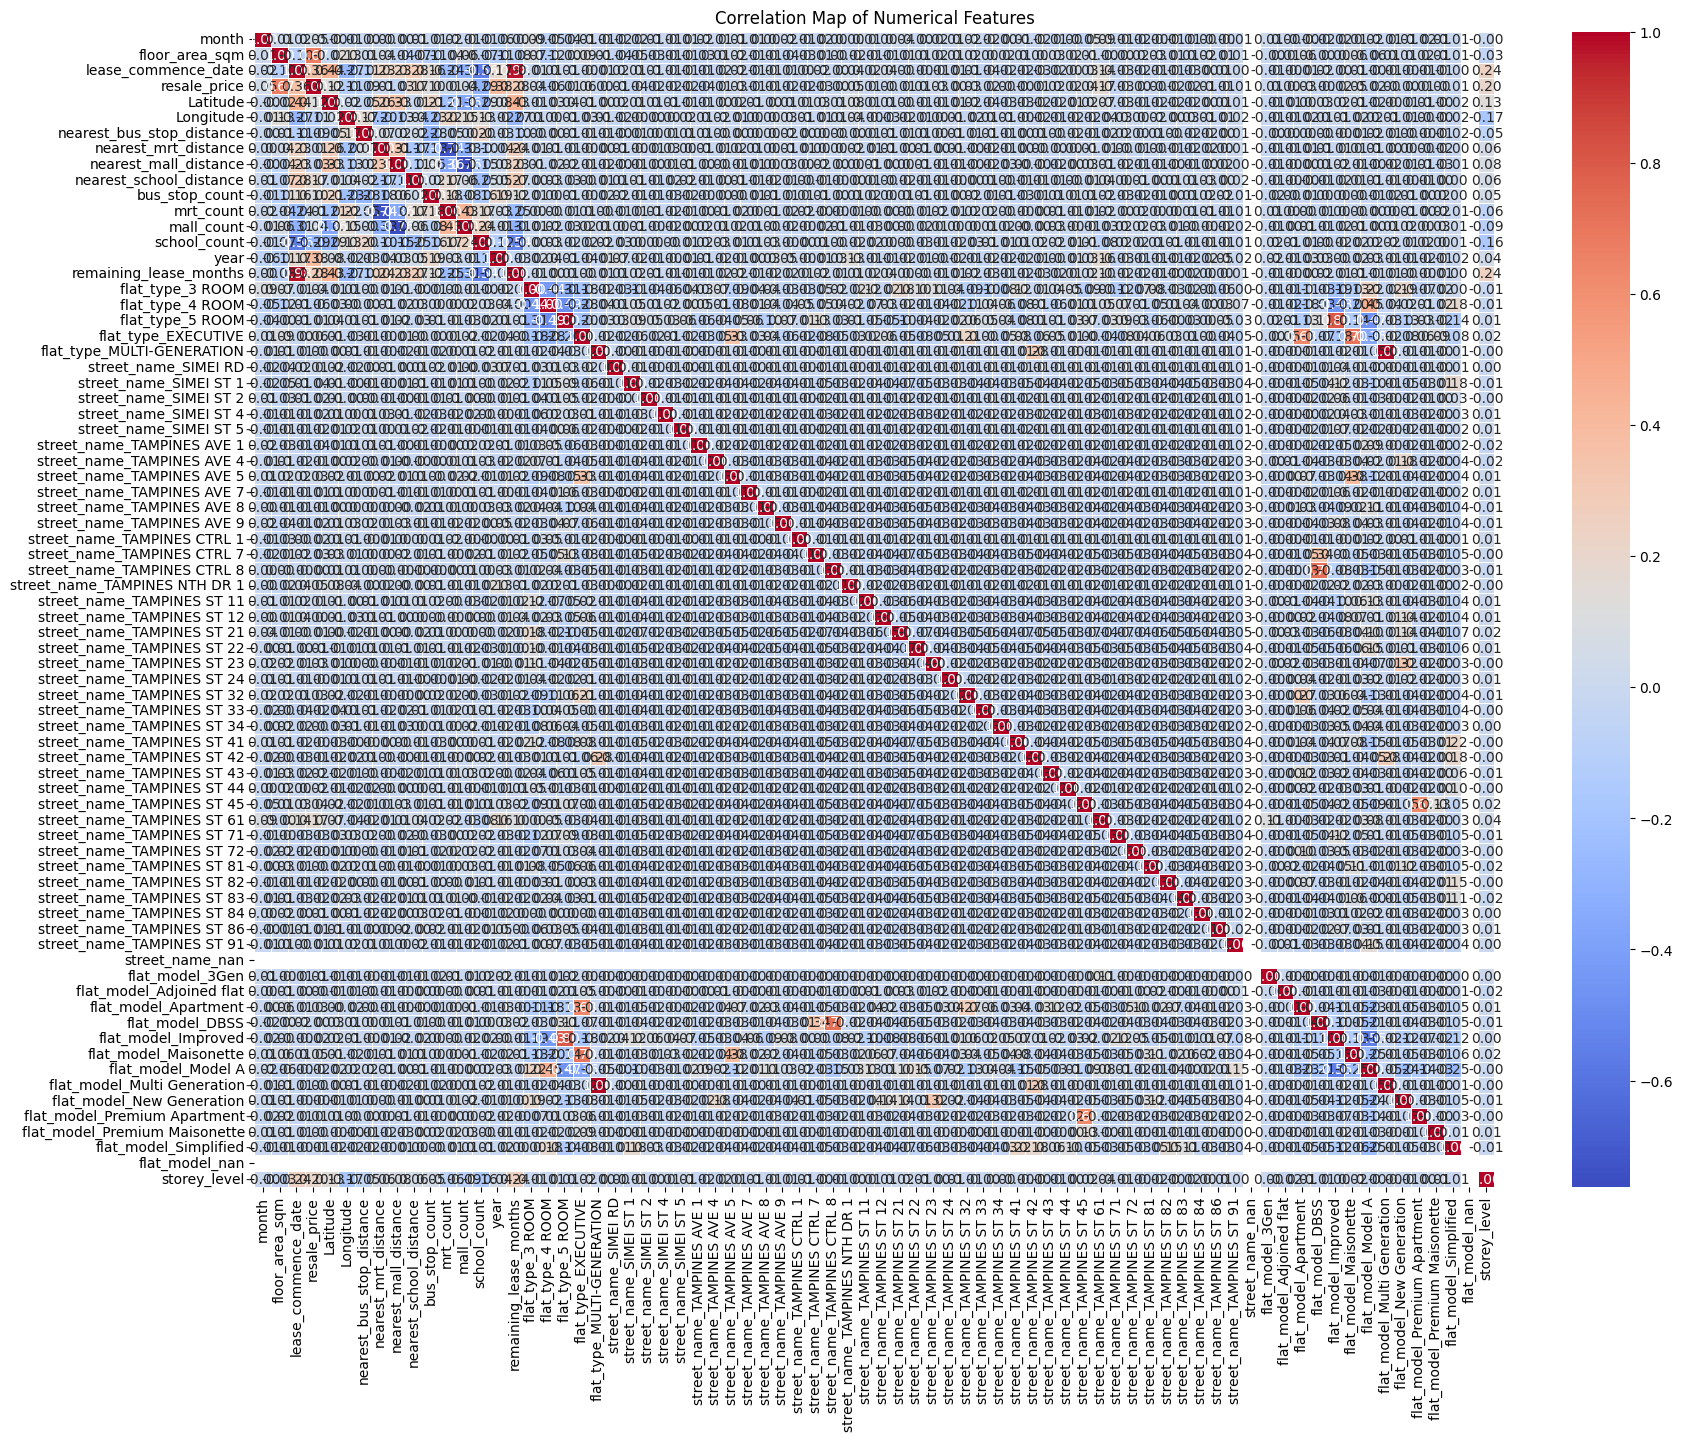

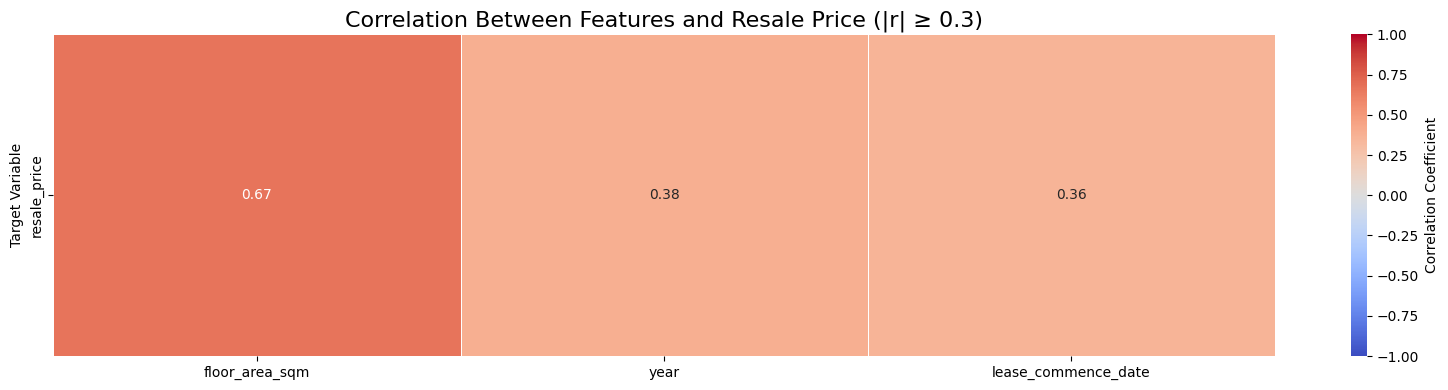

In [4]:
# Select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_features.corr()

# Plot the correlation map
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Map of Numerical Features')
plt.show()

# Select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlations with resale price
price_correlations = numerical_features.corr()['resale_price'].drop('resale_price')

# Define correlation threshold
threshold = 0.3  # You can adjust this value based on your needs

# Filter correlations based on threshold
significant_correlations = price_correlations[abs(price_correlations) >= threshold]

# Sort by absolute correlation value
sorted_correlations = significant_correlations.abs().sort_values(ascending=False)
sorted_features = sorted_correlations.index

# Create a DataFrame for the heatmap
heatmap_df = pd.DataFrame(price_correlations[sorted_features]).T

# Create the heatmap
plt.figure(figsize=(16, 4))
sns.heatmap(heatmap_df, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})

plt.title(f'Correlation Between Features and Resale Price (|r| ≥ {threshold})', fontsize=16)
plt.ylabel('Target Variable')
plt.tight_layout()
plt.show()


# 5) Feature Scaling

In [5]:
# List of numerical features
numerical_features = ['month', 'floor_area_sqm', 'lease_commence_date', 'resale_price',
                      'Latitude', 'Longitude', 'nearest_bus_stop_distance', 'nearest_mrt_distance',
                      'nearest_mall_distance', 'nearest_school_distance', 'bus_stop_count',
                      'mrt_count', 'mall_count', 'school_count', 'year', 'remaining_lease_months',
                      'storey_level']

# List of categorical features (one-hot encoded)
categorical_features = [col for col in df.columns if col not in numerical_features]

# storing values before one hot encoding for xgboost usage
original_numerical_stats = {}
for col in numerical_features:
    original_numerical_stats[col] = {"mean": df[col].mean(), "std": df[col].std()}

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Combine the scaled numerical features with the one-hot encoded categorical features
scaled_df = pd.concat([df[numerical_features], df[categorical_features]], axis=1)

# Display the first few rows of the scaled DataFrame
print(scaled_df.head())

      month  floor_area_sqm  lease_commence_date  resale_price  Latitude  \
0 -1.683811       -2.420165             1.762744     -1.946964 -0.663739   
1 -1.683811       -1.799849            -0.731921     -1.807999  0.742408   
2 -1.683811       -1.469013            -0.824316     -1.634293 -1.398236   
3 -1.683811       -1.427659            -0.731921     -1.599552  0.979585   
4 -1.683811       -1.634431            -0.547131     -1.564811  1.023701   

   Longitude  nearest_bus_stop_distance  nearest_mrt_distance  \
0   0.882588                  -0.684586              0.031269   
1  -0.099482                  -0.715115             -0.612541   
2  -0.848955                   0.204892              1.509028   
3   0.047813                   0.074553              1.122947   
4   1.010286                  -0.313639              0.776805   

   nearest_mall_distance  nearest_school_distance  ...  flat_model_DBSS  \
0              -0.494591                 0.303848  ...              0.0   
1 

# 6) Data Splitting

In [6]:
# Reverse scaling for all numerical features using stored means/stds
for col in numerical_features:
    df[col] = (df[col] * original_numerical_stats[col]["std"]) + original_numerical_stats[col]["mean"]

# Round and convert numerical values back to original form
df["month"] = df["month"].round().astype("Int64")
df["year"] = df["year"].round().astype("Int64")
df["storey_level"] = df["storey_level"].round().astype("Int64")
df["lease_commence_date"] = df["lease_commence_date"].round().astype("Int64")

# Sort dataset by year and month
df.sort_values(by=["year", "month"], ascending=[True, True], inplace=True)

# Now define the training (≤2022) and testing (≥2023) sets
train_df = df[df['year'] <= 2022].copy()
test_df = df[df['year'] >= 2023].copy()

# Define features and target variable
X_train = train_df.drop(columns=["resale_price"])
y_train = train_df["resale_price"]
X_test = test_df.drop(columns=["resale_price"])
y_test = test_df["resale_price"]

print(f"Training set size: {X_train.shape[0]} rows, Testing set size: {X_test.shape[0]} rows")



Training set size: 9276 rows, Testing set size: 3284 rows


# 7) Model Training and Dynamic Hyperparamter Tuning (Bayesian Optimization)

In [26]:
# Define the objective function for Bayesian Optimization with early stopping
def objective(trial):
    """ Bayesian Optimization for SVR with Early Stopping """

    # Define hyperparameter search space
    C = trial.suggest_loguniform('C', 0.1, 100)  # Regularization parameter
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 10.0)  # Epsilon-insensitive loss
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])  # Kernel selection

    # Define SVR model
    model = SVR(C=C, epsilon=epsilon, kernel=kernel)

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    # Compute the mean RMSE score
    score = -cv_scores.mean()  # Convert to positive RMSE

    # Report intermediate results for pruning
    trial.report(score, step=1)

    # Check if we should stop this trial early
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return score  # Optuna minimizes RMSE

# Run Bayesian Optimization with Early Stopping (Pruning)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=30)  # Run 30 trials with early stopping

# Print best hyperparameters
print("Best Hyperparameters for SVR:", study.best_params)

# Train the final SVR model using best parameters
best_params = study.best_params
best_model = SVR(**best_params)
best_model.fit(X_train, y_train)

print("SVR Model Training Complete!")

[I 2025-03-03 19:39:31,637] A new study created in memory with name: no-name-de8811c8-3b9e-4c4d-9091-82f8aee00230
<ipython-input-26-87bf3624cb1c>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)  # Regularization strength
[I 2025-03-03 19:39:31,817] Trial 0 finished with value: 68214.92364907773 and parameters: {'alpha': 0.011167517552799435}. Best is trial 0 with value: 68214.92364907773.
<ipython-input-26-87bf3624cb1c>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)  # Regularization strength
[I 2025-03-03 19:39:31,979] Trial 1 finished with value: 68260.171314

Best Hyperparameters: {'alpha': 0.22499354286624876}
Model Training Complete!


# 8) Model Evaluation

In [27]:
# Make predictions
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error (RMSE)
mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error (MAE)
r2 = r2_score(y_test, y_pred)  # R² Score

# Calculate Prediction Accuracy
mean_actual_price = np.mean(y_test)  # Average of actual resale prices
prediction_accuracy = 100 - ((mae / mean_actual_price) * 100)  # Accuracy in %

# Print evaluation results with explanations
print("\n📊 Model Performance on Test Set:")
print(f"📌 RMSE (Root Mean Squared Error): {rmse:,.2f}")
print("   - RMSE tells us the **typical size of the prediction errors**.")
print("   - It **penalizes large errors more**, so big mistakes affect it more.")
print(f"   - This means that, on average, predictions are off by about **${rmse:,.0f}**.")

print(f"\n📌 MAE (Mean Absolute Error): {mae:,.2f}")
print("   - MAE is the **average of all absolute errors**.")
print("   - It treats **all errors equally**, whether big or small.")
print(f"   - This means that, on average, predictions are off by about **${mae:,.0f}**.")

print(f"\n📌 R² Score (Coefficient of Determination): {r2:.4f}")
print("   - R² shows how well the model explains the variance in resale prices.")
print("   - **1.0 = Perfect model, 0.0 = No better than random guessing.**")
print(f"   - This model explains about **{r2*100:.2f}%** of the variation in resale prices.")

# Print Prediction Accuracy
print(f"\n🎯 Prediction Accuracy: {prediction_accuracy:.2f}%")
print("   - This means that, on average, the model predicts **within this percentage** of actual prices.")


📊 Model Performance on Test Set:
📌 RMSE (Root Mean Squared Error): 79,318.91
   - RMSE tells us the **typical size of the prediction errors**.
   - It **penalizes large errors more**, so big mistakes affect it more.
   - This means that, on average, predictions are off by about **$79,319**.

📌 MAE (Mean Absolute Error): 61,181.65
   - MAE is the **average of all absolute errors**.
   - It treats **all errors equally**, whether big or small.
   - This means that, on average, predictions are off by about **$61,182**.

📌 R² Score (Coefficient of Determination): 0.6641
   - R² shows how well the model explains the variance in resale prices.
   - **1.0 = Perfect model, 0.0 = No better than random guessing.**
   - This model explains about **66.41%** of the variation in resale prices.

🎯 Prediction Accuracy: 89.97%
   - This means that, on average, the model predicts **within this percentage** of actual prices.


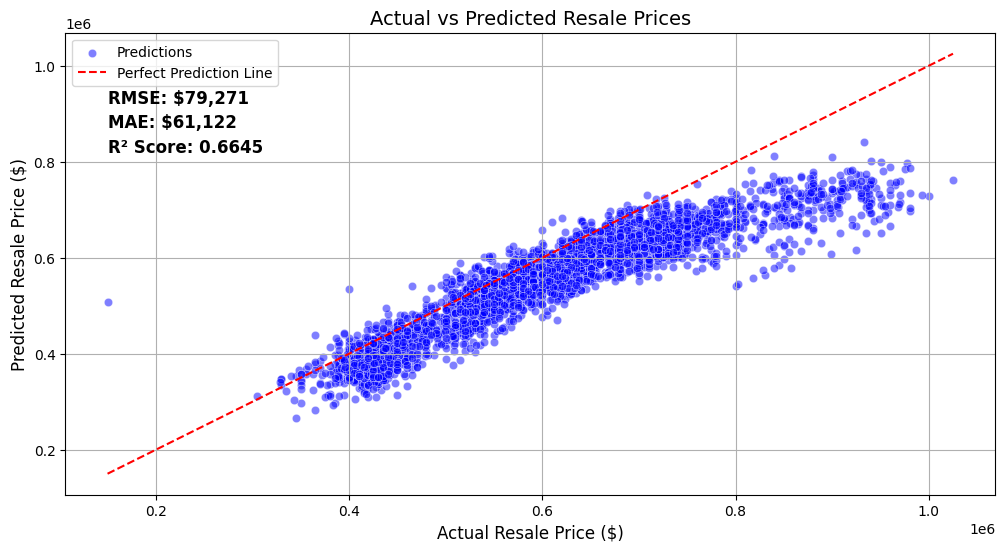

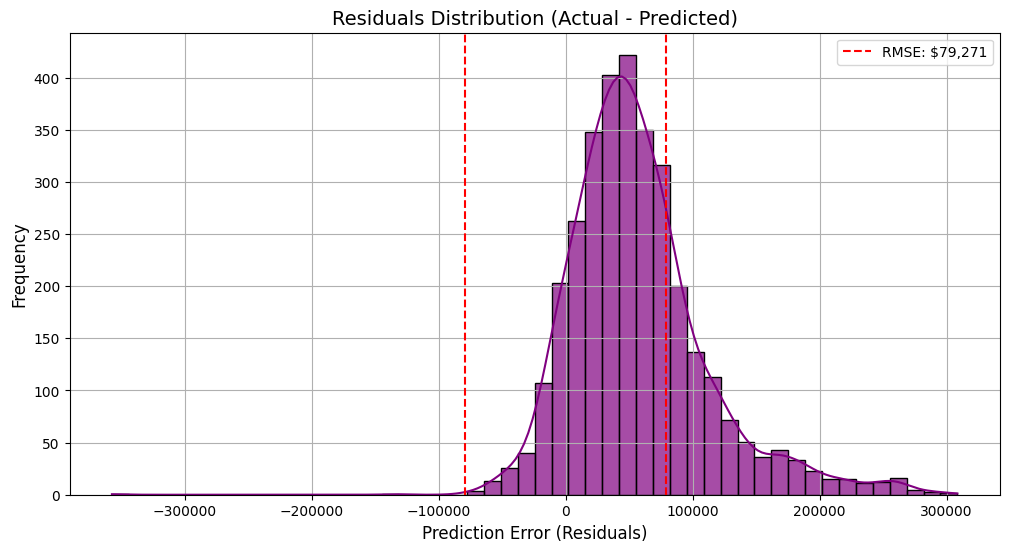

In [13]:
# Scatter Plot: Actual vs Predicted Prices
plt.figure(figsize=(12, 6))

# Scatter plot of actual vs predicted prices
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, label="Predictions", color="blue")

# Perfect predictions line (red dashed line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label="Perfect Prediction Line")

# Highlighting RMSE, MAE, and R² values on the graph for clarity
plt.text(y_test.min(), y_test.max()*0.9, f"RMSE: ${rmse:,.0f}", fontsize=12, color="black", weight="bold")
plt.text(y_test.min(), y_test.max()*0.85, f"MAE: ${mae:,.0f}", fontsize=12, color="black", weight="bold")
plt.text(y_test.min(), y_test.max()*0.80, f"R² Score: {r2:.4f}", fontsize=12, color="black", weight="bold")

# Labels and title
plt.xlabel("Actual Resale Price ($)", fontsize=12)
plt.ylabel("Predicted Resale Price ($)", fontsize=12)
plt.title("Actual vs Predicted Resale Prices", fontsize=14)
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Residuals Plot: Distribution of Prediction Errors
plt.figure(figsize=(12, 6))
residuals = y_test - y_pred  # Calculate residuals (error)

# Histogram of residuals
sns.histplot(residuals, bins=50, kde=True, color="purple", alpha=0.7)

# Highlighting RMSE on residuals plot
plt.axvline(x=rmse, color='red', linestyle='dashed', label=f"RMSE: ${rmse:,.0f}")
plt.axvline(x=-rmse, color='red', linestyle='dashed')

plt.xlabel("Prediction Error (Residuals)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Residuals Distribution (Actual - Predicted)", fontsize=14)
plt.legend()
plt.grid(True)

# Show plot
plt.show()